# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

Let's start!

## Camera Calibration

Camera calibration is carried out using the supplied images in the `camera_cal` folder. The images here are photos taken of a chessboard figure from twenty different angles.

Aside from the images, the target chessboard size should be provided for the opencv2 library to detect correctly (values nx and ny). This code is based on the video shown in Chapter 10 of this lesson. All images that have a correctly identifiable chessboard are outputted below (17 out of 20).

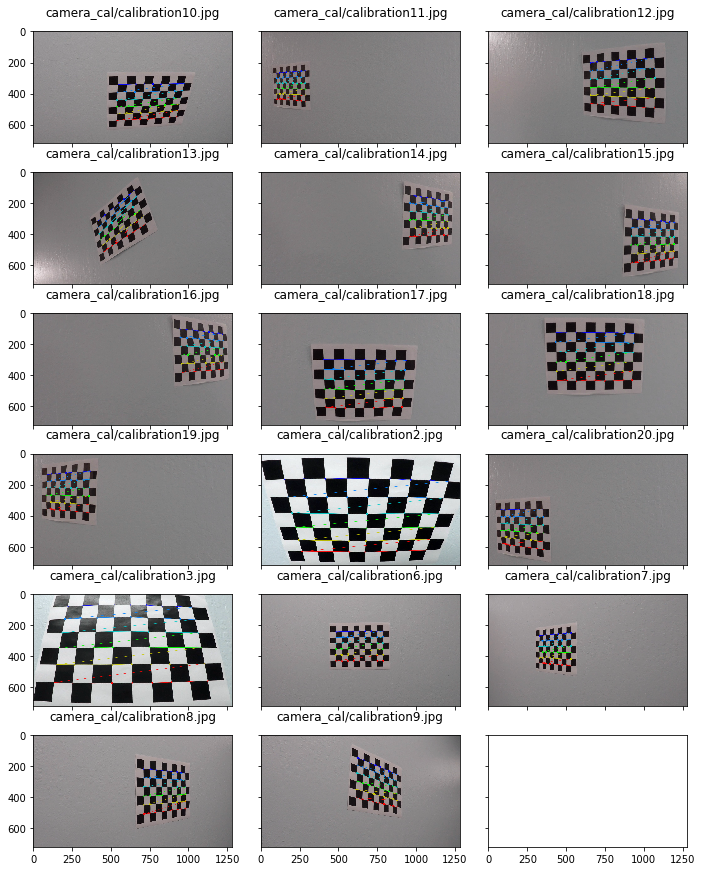

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline

nx = 9 # Horizontal corners
ny = 6 # Vertical corners

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
calimages = []

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Create a grid for image visualization
figure = plt.figure(1, (15., 15.))
rows = 6
cols = 3
i = 0
image_grid = ImageGrid(figure, 111, nrows_ncols=(rows, cols), axes_pad=0.4)

for fname in images:
    # Read the image
    img = cv2.imread(fname)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points and send to plot
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        calimages.append(img)
        image_grid[i].set_title(fname, y=1.08)
        image_grid[i].imshow(img)
        i = i + 1
    
plt.show()

## Distortion correction on a test image

After processing the images above, the next step is to correct distortion. By specificing the specific image index we want to test (in this case, 11), we obtain an original and undistorted version of the image. This code is based on the quiz from Chapter 11 of this lesson.

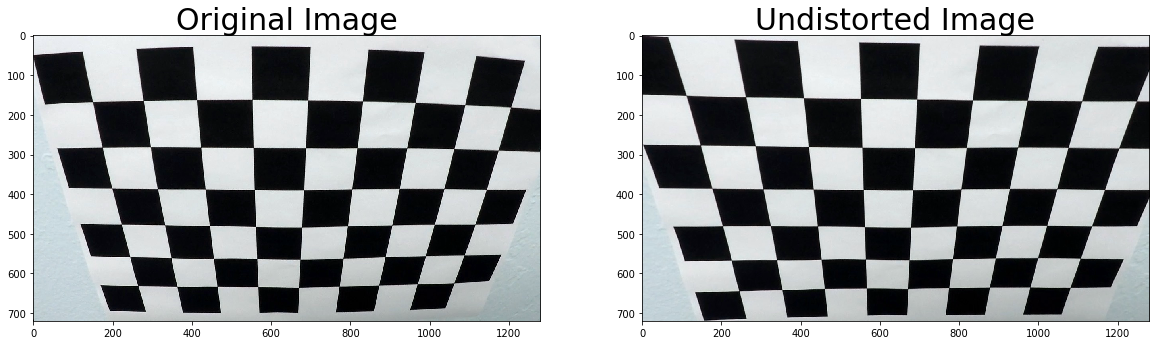

In [2]:
import pickle

image_num = 11

# Load image
img = cv2.imread(images[image_num])
img_size = (img.shape[1], img.shape[0])

# Recalculate corners
    
# Calibrate and undistort, recalculate corners for warp
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save original and undistorted image for reference in output_images folder
cv2.imwrite('output_images/camera_cal_test_dist.jpg', img)
cv2.imwrite('output_images/camera_cal_test_undist.jpg', dst)

# Save camera calibration result
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Distortion correction on raw images

Let's try the same with one of the raw images featured in the repository. 

*NOTE: We are assuming that images taken of the chessboard and from the car are using the same camera model.*

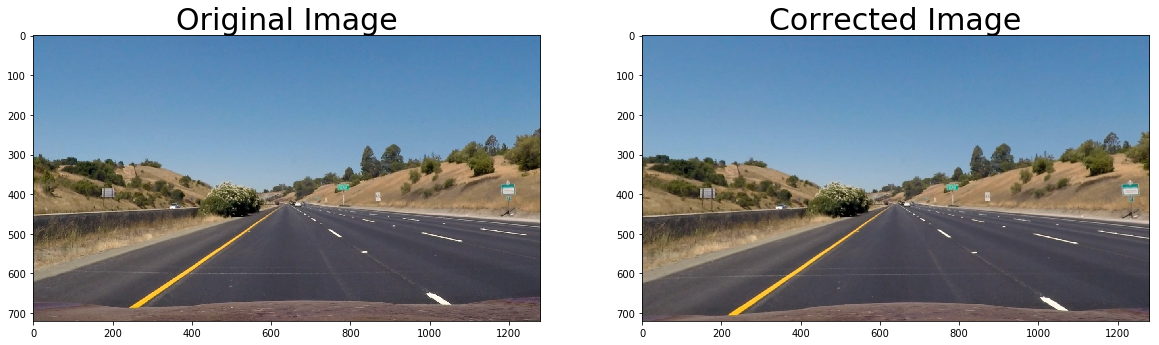

In [3]:
import matplotlib.image as mpimg

img = mpimg.imread('test_images/straight_lines1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Corrected Image', fontsize=30)

## Thresholded binary image

To continue processing the images, we need to create a thresholded binary image by running frames through color transforms, gradients, etc. 

#### Equalize

This function transforms the image to a YUV color space, then equalizes the histogram of the Y channel and returns the original RGB image.

In [4]:
def equalize(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img_yuv[:, :, 0] = cv2.equalizeHist(img_yuv[:, :, 0])
    img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    
    return img_output

#### Gamma correction

Darken the image by adjusting its gamma.

In [5]:
def gamma(img, correction):
    img = img/255.0
    img = cv2.pow(img, correction)
    
    return np.uint8(img * 255)

### Pipeline

Workflow for generating the thresholded binary image.

1. Explore Sobel operator on a grayscale image (Code based on Chapter 20 of this lesson).
2. Explore HLS color space.
3. Combine binary images.

In [6]:
def tbi_pipeline(image, sxthresh=(20,50), hthresh=(17,50), lthresh=(240,255), sthresh=(220,255)):
    image = np.copy(gamma(equalize(image),1.35))
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sxthresh[0]) & (scaled_sobel <= sxthresh[0])] = 1
    
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    # H channel
    H = hls[:,:,0]
    binary_h = np.zeros_like(H)
    binary_h[(H > hthresh[0]) & (H <= hthresh[1])] = 1
    
    # L channel
    L = hls[:,:,1]
    binary_l = np.zeros_like(L)
    binary_l[(L > lthresh[0]) & (H <= lthresh[1])] = 1
    
    # S channel
    S = hls[:,:,2]
    binary_s = np.zeros_like(S)
    binary_s[(S > sthresh[0]) & (S <= sthresh[1])] = 1
    
    # Combine H + L + S
    binary_hs = np.zeros_like(binary_s)
    binary_hs[(binary_h == 1) | (binary_l == 1) | (binary_s == 1)] = 1
    
    # Combine Sibel + HLS
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(binary_hs == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

#### Pipeline test

Let's run the pipeline through all images in the test_images folder.

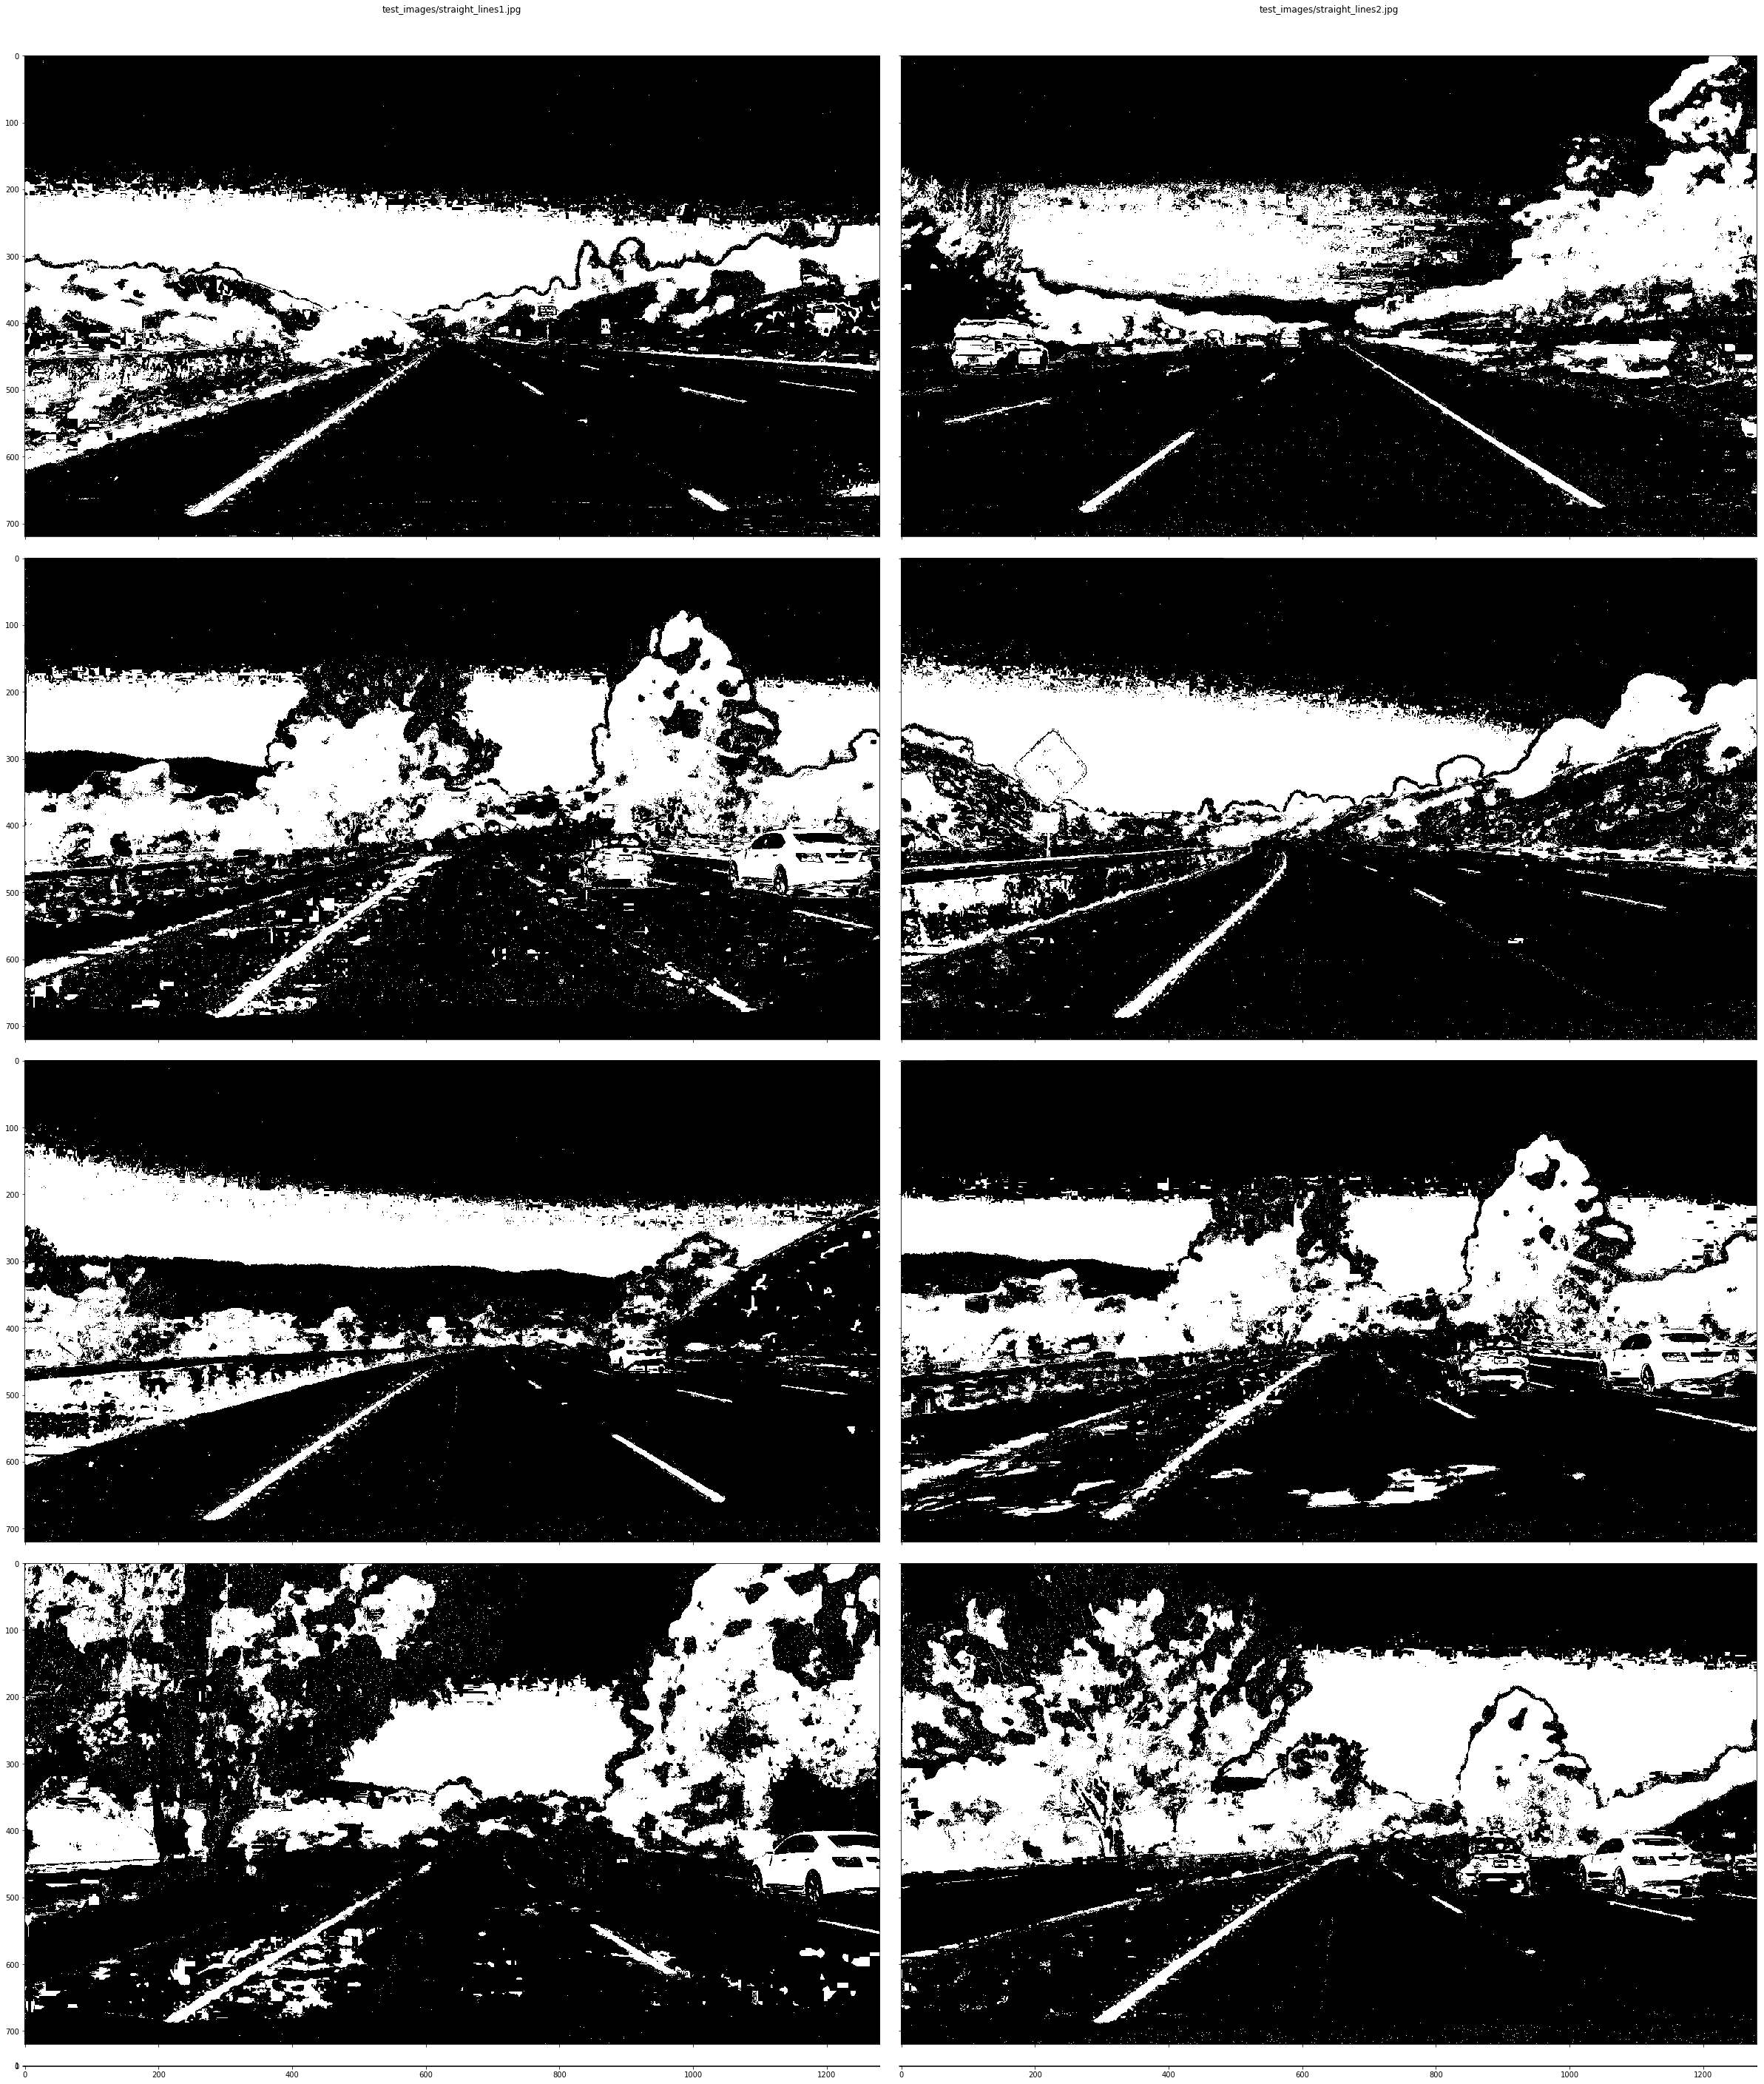

In [7]:
sxt=(20,50) # xgradient
hht=(17,50) # h channel
lht=(240,255) # l channel
sht=(220,255) # s channel

straight_lines_images = glob.glob('test_images/straight_lines*.jpg')
test_images = glob.glob('test_images/test*.jpg')

images = straight_lines_images + test_images

figure = plt.figure(1, (50., 50.))
rows = 5
cols = 2
i = 0
image_grid = ImageGrid(figure, 111, nrows_ncols=(rows, cols), axes_pad=0.4)

pipeline_images = []
tbi_images = []

for fname in images:
    img = mpimg.imread(fname)
    tbi_img = tbi_pipeline(img, sxt, hht, lht, sht)
    pipeline_images.append(img)
    tbi_images.append(tbi_img)
    
    image_grid[i].set_title(fname, y=1.08)
    image_grid[i].imshow(tbi_img, cmap='gray')
    i = i + 1
    
plt.show()

## Perspective transform for binary image rectification (warp)

At this point, we need to apply a perspective transformation to the images. 

1. Apply a region mask (reusing the `region_of_interest` function provided in Project 1).
2. Run warp on the masked region.

In [8]:
# Hard-coded vertices in the function

def region_of_interest(img, vertices = np.array(
    [
        [
            [80,720],
            [578,400],
            [702,400],
            [1200,720]
        ]
    ],
    np.int32)):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

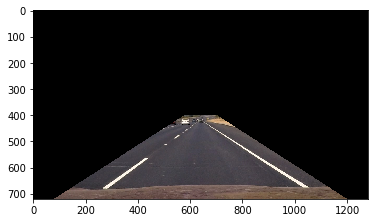

In [9]:
# Show a region-masked pipeline image
plt.imshow(region_of_interest(pipeline_images[1]), cmap='gray')

In [10]:
src_points = np.float32(
        [[0,720],
         [578,450],
         [702,450],
         [1280,720]])

dst_points = np.float32(
        [[320,720],
         [320,0],
         [960,0],
         [960,720]])

def warp(img):
    img_size=(img.shape[1],img.shape[0])    
    
    # Compute the perspective transform matrix M
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    
    # Create the warped image using linear interpolation
    warped = cv2.warpPerspective(region_of_interest(img), M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

In [11]:
def transform(image):
    image_und = cv2.undistort(image, mtx, dist, None, mtx)
    transform_image = warp(image_und)
    
    return transform_image

def transform_combined(image, sxt, hht, lht, sht):
    image_und = cv2.undistort(image, mtx, dist, None, mtx)
    transform_combined_image = warp(tbi_pipeline(image_und, sxt, hht, lht, sht))
    
    return transform_combined_image    

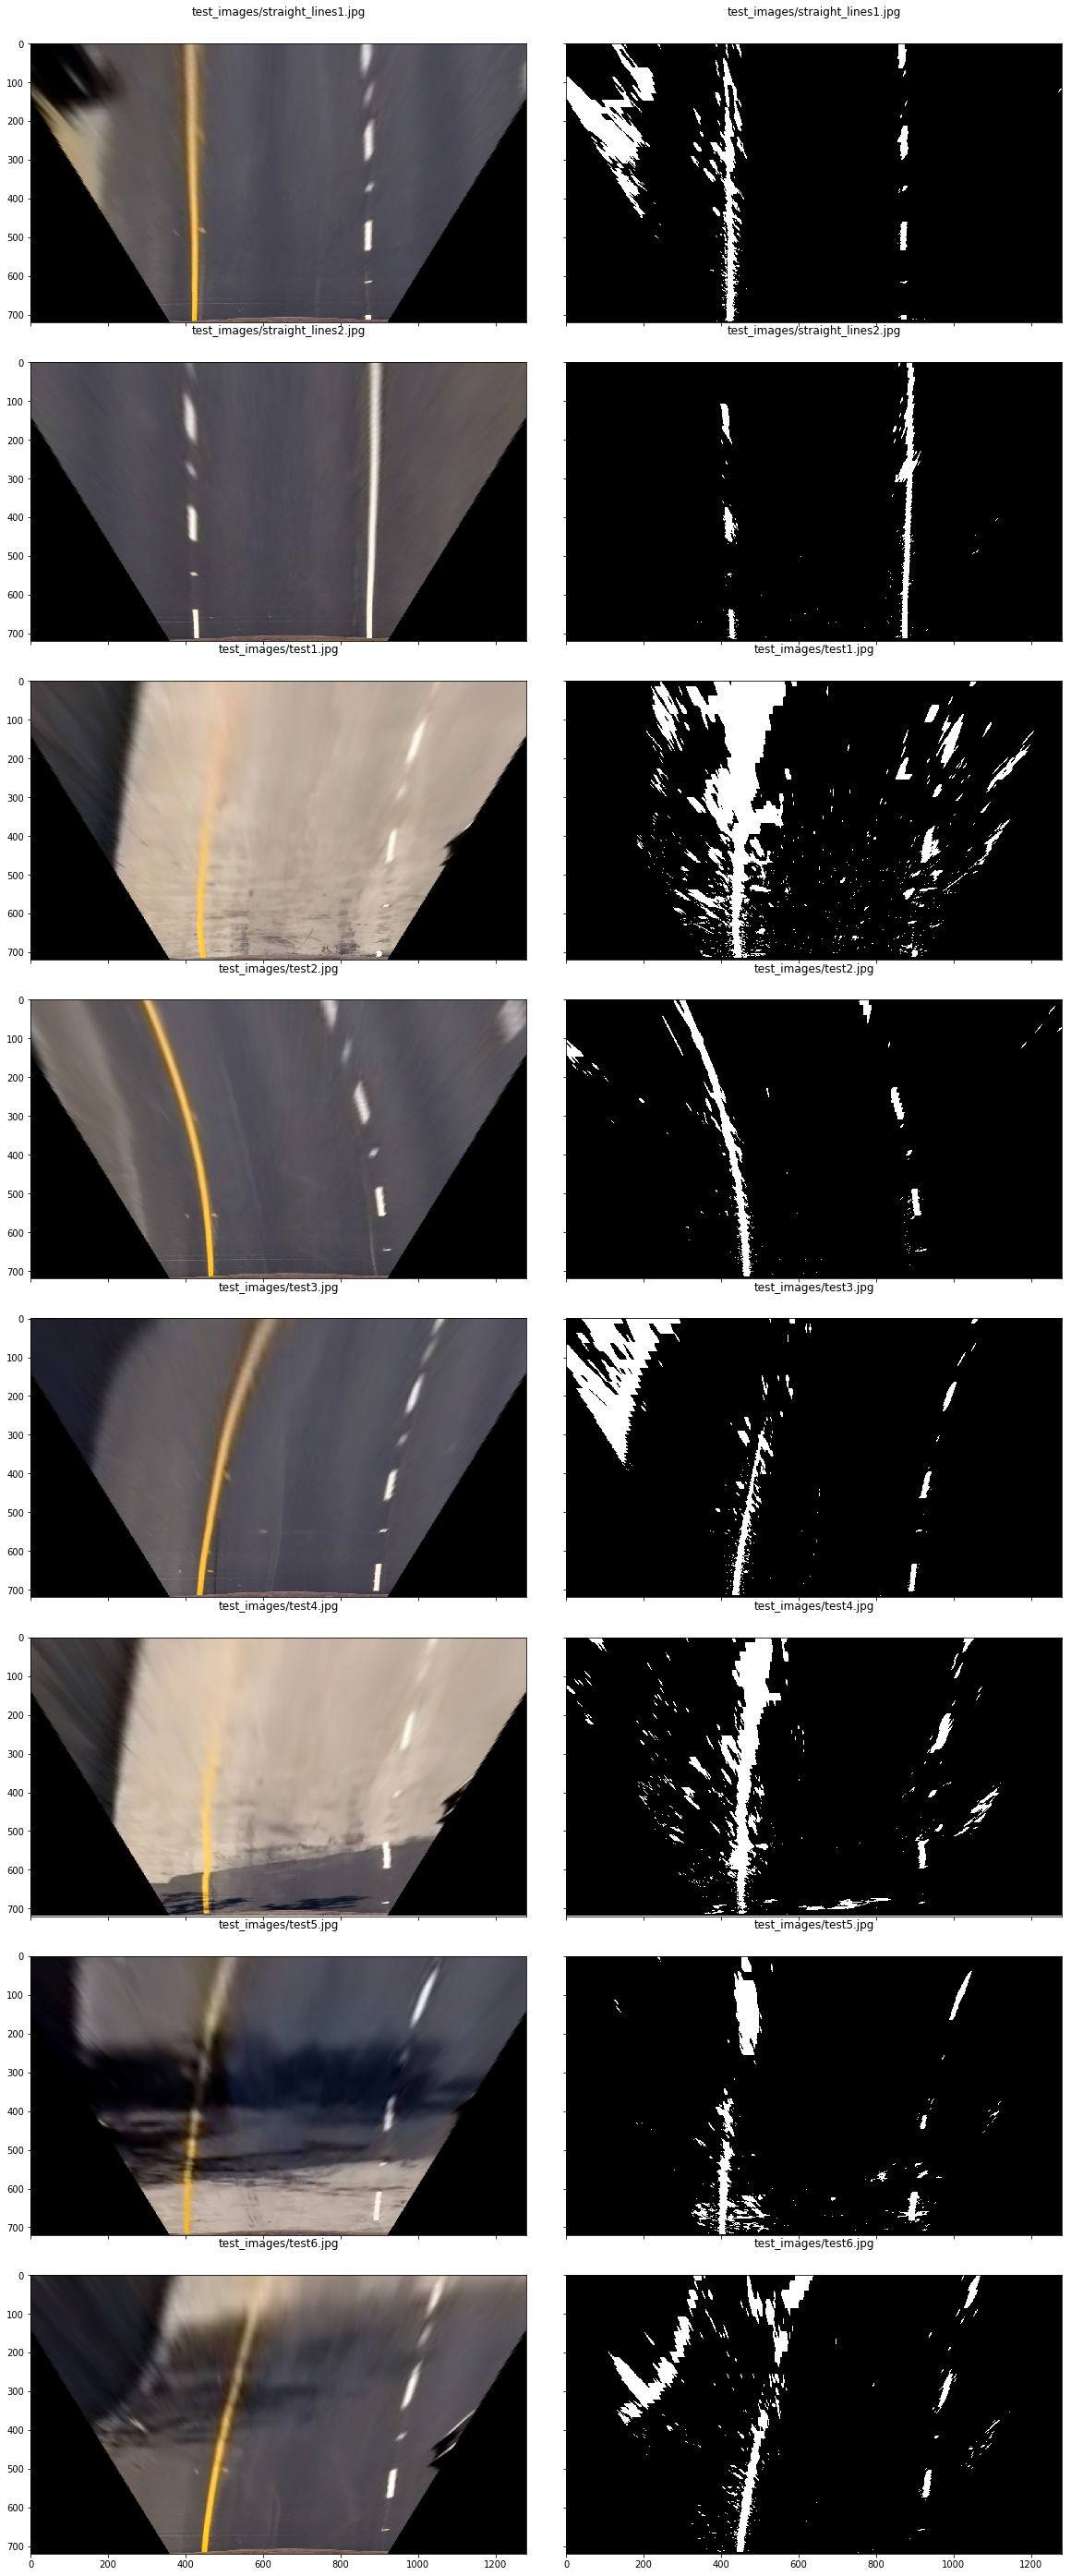

In [12]:
figure = plt.figure(1, (50., 50.))
rows = 8
cols = 2
i = 0
j = 0
image_grid = ImageGrid(figure, 111, nrows_ncols=(rows, cols), axes_pad=0.6)

for pipeline_image in pipeline_images:
    # Raw image
    image_grid[j].set_title(images[i], y=1.08)
    image_grid[j].imshow(transform(pipeline_image), cmap='gray')
    
    # Binary image
    image_grid[j+1].set_title(images[i], y=1.08)
    image_grid[j+1].imshow(transform_combined(pipeline_image, sxt, hht, lht, sht), cmap='gray')
    i = i + 1
    j = j + 2

## Detect lane pixels and fit to find the lane boundary 

The following code is based on the examples provided in Chapter 33 of this lesson, although I made some changes to conditionally run the histogram and refenerate left/right_lane_inds only if it's the first lane detection. 

In [13]:
def detect_lane(binary_warped):
    global first_run
    global left_fit
    global right_fit
    
    # Set the width of the windows +/- margin
    margin = 75
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    if first_run == False:
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    if first_run == True:
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Take a histogram of the 3/4 bottom of the image
        histogram = np.sum(binary_warped[int(binary_warped.shape[0]*3/4):,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            # low and high height of the window
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            # x location of the extremes of the left window
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            # x location of the extremes of the right window
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
        # null first_run flag
        first_run = False
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
        
    return left_lane_inds, right_lane_inds, nonzerox,nonzeroy, first_run

In [14]:
def plot_lines(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzerox, nonzeroy):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    return left_fitx, right_fitx

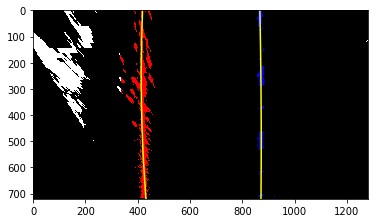

In [15]:
binary_warped = transform_combined(pipeline_images[0], sxt, hht, lht, sht)
first_run = True 
l_l_i,r_l_i,nzx,nzy,first_run=detect_lane(binary_warped)
left_fitx, right_fitx = plot_lines(binary_warped, left_fit, right_fit, l_l_i, r_l_i, nzx, nzy)


### Determine the curvature of the lane and vehicle position with respect to center.

Since curvature is calculated using pixel space instead of real world space, we need to convert. The `ym_per_pix` and `xm_per_pix` parameters enable this conversion. Although Chapter 35 provides an example, I thought it would be interesting to calculate this dynamically using parameters from plot_lines.

In [16]:
xm_per_pix = 3.7/(right_fitx[719]-left_fitx[719])
ym_per_pix = 3.0/(528-475)

print(xm_per_pix)
print(ym_per_pix)

0.00841050625688
0.05660377358490566


### Curvature

The curvature function defined below is based on the one provided by Chapter 35, altered to be used in the video pipeline. The curvature_factor function combines both lane line data.

In [17]:
# Curvature calculation
def curvature(binary_warped, polyfit, xm_per_pix, ym_per_pix, y_eval):
    x=[]
    y=[]

    A = polyfit[0]
    B = polyfit[1]
    C = polyfit[2]

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    for i in range(len(ploty)):
        x.append((A* (ploty[i]**2) + B * (ploty[i]) + C) * xm_per_pix)
        y.append(ploty[i] * ym_per_pix)

    poly_fit_real = np.polyfit(y,x,2)
    arw = poly_fit_real[0]
    brw = poly_fit_real[1]

    # RCurve formula
    radius = ((1+(2*arw*y_eval+brw)**2)**1.5)/(abs(2*arw))
    return int(radius)

def curvature_factor(binary_warped,left_fit, right_fit, xm_per_pix, ym_per_pix):
    left_curvature = curvature(binary_warped, left_fit, xm_per_pix, ym_per_pix, 710)
    right_curvature = curvature(binary_warped, right_fit, xm_per_pix, ym_per_pix, 710)
    lane_curvature = int((left_curvature + right_curvature)/2)
    
    return lane_curvature

### Offset

The offset function defined below returns an estimated deviation from the lane center.

In [18]:
# Offset calculation
def offset_center(polyfit_left, polyfit_right, xm_per_pix):
    A_left = polyfit_left[0]
    B_left = polyfit_left[1]
    C_left = polyfit_left[2]
    x_left = A_left * (720**2) + B_left * 720 + C_left
    
    A_right = polyfit_right[0]
    B_right = polyfit_right[1]
    C_right = polyfit_right[2]
    x_right = A_right * (720**2) + B_right * 720 + C_right
    
    offset = ((x_right + x_left) / 2) - 640
    offset_rw = offset*xm_per_pix
    
    return round(offset_rw,3)

## Warp the detected lane boundaries back onto the original image.

`map_lane` is loosely based on code from Chapter 36.

In [19]:
def x_points(binary_warped, polifit):

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    ploty = ploty[200:720]
    
    A = polifit[0]
    B = polifit[1]
    C = polifit[2]
    x = []
    
    for i in range(len(ploty)):
        x.append(A * (ploty[i]**2) + B * ploty[i] + C)
    
    return ploty,x

In [20]:
def map_lane(binary_warped, image, polyleft, polyright, xm_per_pix=xm_per_pix, ym_per_pix=ym_per_pix):
    lane_curvature = curvature_factor(binary_warped, polyleft, polyright, xm_per_pix, ym_per_pix)
    offset = offset_center(polyleft, polyright, xm_per_pix)
    ploty, left_fitx = x_points(binary_warped, polyleft)
    right_fitx = x_points(binary_warped,polyright)[1]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Compute the inverse perspective transform matrix M
    M_inv = cv2.getPerspectiveTransform(dst_points, src_points)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (image.shape[1], image.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    # OSD-type telemetry
    osd_radius = 'Radius: '+str(lane_curvature)+'(m)'
    
    if offset < 0:
        osd_offset = 'Offset: '+str(-offset)+'m'
    if offset > 0:
        osd_offset = 'Offset: '+str(offset)+'m'
    if offset == 0:
        osd_offset = 'Offset: none'
        
    cv2.putText(result, osd_radius, (130,100), cv2.FONT_HERSHEY_PLAIN, 3.5, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(result, osd_offset, (130,200), cv2.FONT_HERSHEY_PLAIN, 3.5, (255,255,255), 2, cv2.LINE_AA)
    
    return result

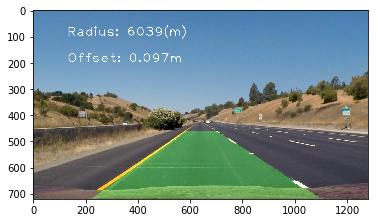

In [21]:
plt.imshow(map_lane(binary_warped, pipeline_images[0], left_fit, right_fit))

## Video Export

At this point we have a reasonable result that can be overlayed on a video. Further research (and a desire to prevent jitter in the overlay) provided me with a path to stabilize the lines layed out on the video (defined in `smoothing`).

In [22]:
## Export to video
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import io
import base64

def poly_smooth(left_poly, right_poly, nsmooth=7):
    global left_polys, right_polys
    
    if nsmooth > len(left_polys):
        left_polys.append(left_poly)
        right_polys.append(right_poly)
        
    if nsmooth <= len(left_polys):
        left_polys=left_polys[1:nsmooth]
        left_polys.append(left_poly)
        right_polys=right_polys[1:nsmooth]
        right_polys.append(right_poly)
        
    left_f = np.mean(np.asarray(left_polys),axis=0)
    right_f = np.mean(np.asarray(right_polys),axis=0)
    return left_f, right_f

def process_image(image):
    binary_warped = transform_combined(image,sxt,hht,lht,sht)
    l_l_i,r_l_i,nzx,nzy,first_run = detect_lane(binary_warped)
    left_f,right_f = poly_smooth(left_fit,right_fit,7)
    result = map_lane(binary_warped,image,left_f,right_f)
    
    return result

first_run = True
left_polys = []
right_polys = []
visual_output = 'output_images/project_output.mp4'

clip1 = VideoFileClip("project_video.mp4")
output_clip=clip1.fl_image(process_image)
%time output_clip.write_videofile(visual_output, audio=False)

[MoviePy] >>>> Building video output_images/project_output.mp4
[MoviePy] Writing video output_images/project_output.mp4


100%|█████████▉| 1260/1261 [06:51<00:00,  3.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_output.mp4 

CPU times: user 6min 18s, sys: 1min 49s, total: 8min 8s
Wall time: 6min 53s


In [23]:
first_run = True
left_polys = []
right_polys = []
visual_output = 'output_images/challenge_project_output.mp4'

clip1 = VideoFileClip("harder_challenge_video.mp4")
output_clip=clip1.fl_image(process_image)
%time output_clip.write_videofile(visual_output, audio=False)

[MoviePy] >>>> Building video output_images/challenge_project_output.mp4
[MoviePy] Writing video output_images/challenge_project_output.mp4


100%|█████████▉| 1199/1200 [06:49<00:00,  3.33it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_project_output.mp4 

CPU times: user 6min 21s, sys: 1min 48s, total: 8min 10s
Wall time: 6min 52s
